# Quanvolutional Neural Networks

<img height="60%" width="60%" src="https://pennylane.ai/_images/circuit3.png"/>

One branch of classical machine learning is the image-processing. The standard model to process images is **convolutional neural network** (CNN). Basically, small regions of pixels are created on an image. Sequentially, these regions are processed with the same kernel. Each region produce a single value as an output. These outputs combined can create another level of regions, larger than the previous regions. The procedure is repeated until the whole image is scanned.

**Quanvolutional neural network** (QNN) is the CNN with inputs encoded into quantum states. It raises a huge potential to generate highly complex kernels compared to classical ones. We will explore how QNN works in this notebook.

# Environment Preparation
We need to install PennyLane if it is not installed yet. Then, we import necessary libraries for this tutorial.

In [1]:
# %pip install pennylane # uncommment this to install

In [2]:
# import libraries
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Setting Hyper-parameters
We need to define how many times we train, how many layers we use, the size of the dataset, the directory to our data, seed values for reproducibility for numpy and tensorflow.

In [3]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

# Loading and Preparing MNIST Dataset
This dataset is taken from *Keras*. Here, we use a small portion of our data to speedup our training. As a consequence, this creates a model which can be refined with larger data. We normalize our pixel data to be in a range of 0 ad 1.

In [4]:
# Load data
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

# Quantum Circuit
- The default device is created with four default qubits which are initialized in ground states.
- These qubits are subject to the $R_y$ operation to encode 4 classical input values.
- Then, a random circuit is implemented with `n_layers`.
- Four expectation values is measured in the computational basis with the Pauli-Z observable. Each of the four values is in the range $[-1, 1]$ because it is a weighted average of the possible measurement outcomes.

In [5]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

# Convolution Scheme
An image is divided into small $2\times 2$ pixels to halve the image resolution. This process is equivalent to using $2\times 2$ *kernel* and a *stride* of 2 for a classical CNN. Unlike CNN, each square is processed by the quantum circuit. Four expectation values are mapped into four different channels of a single output pixel.

In [6]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

# Quantum Pre-processing
To implement QNN, we need to make a few quantum pre-processings. Without this step, the implementation will be CNN. Moreover, these new data should be saved for reuse.

In [7]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


# Visualization
Visualizing images shows us that the image is processed in four different ways with four different channels (or should we say, four different qubits!). This helps the model to understand the general shape of an object within an image rather than the particular picture. This gives the model an ability to recognize more general patterns. 

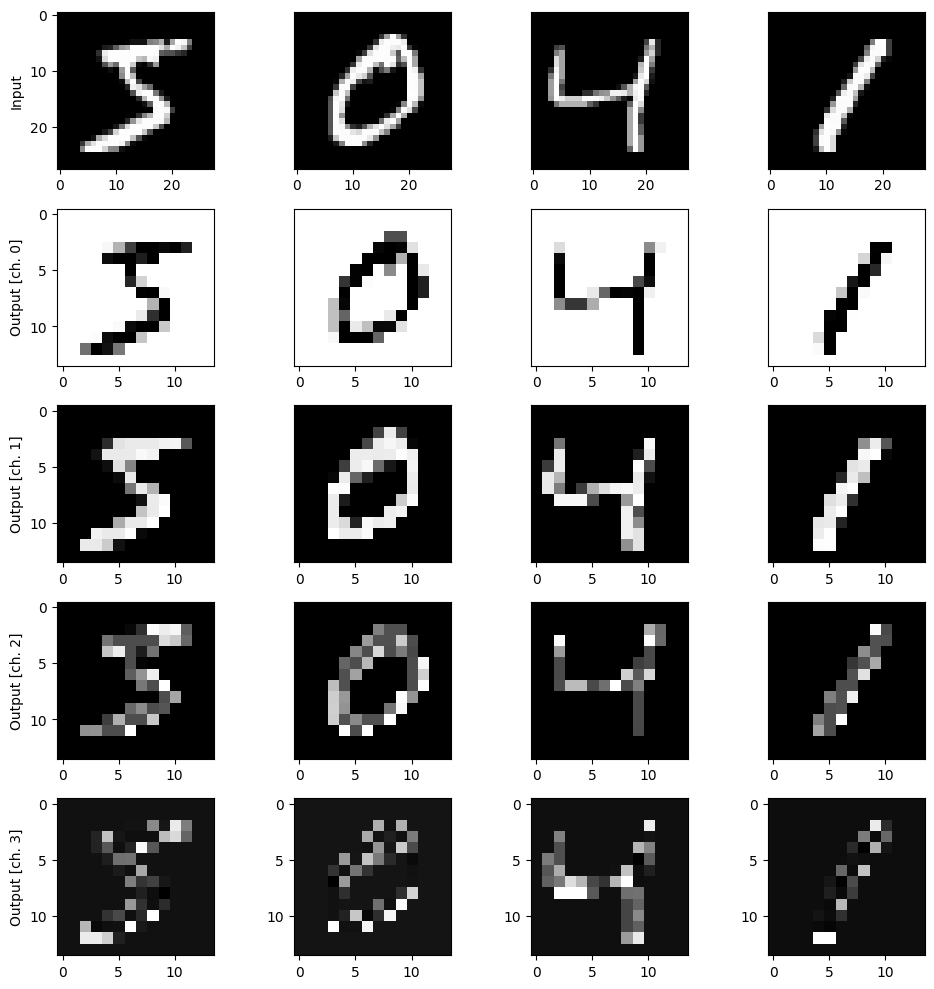

In [8]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

# Hybrid Quantum-Classical Model
We define a model that can either be quantum or classical depends on the input.
- If we use quantum pre-processed data, it will be QNN.
- If we do not use quantum pre-processed data, it will be CNN.

We create a sequential model with flattened layers. We choose an "adam" optimizer for our model with pre-defined functions for loss and accuracy evaluation. The model is compiled after this step.

In [9]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

## Quantum Model Training
To make comparisons, we create QNN by initializing a “quantum” instance of the model with quantum pre-processed data.

In [10]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images, # 'q_train_images'
    train_labels,
    validation_data=(q_test_images, test_labels), # 'q_test_images'
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 53ms/step - accuracy: 0.0800 - loss: 2.9254 - val_accuracy: 0.1667 - val_loss: 2.3928
Epoch 2/30
13/13 - 0s - 5ms/step - accuracy: 0.2400 - loss: 1.9735 - val_accuracy: 0.2000 - val_loss: 2.1931
Epoch 3/30
13/13 - 0s - 5ms/step - accuracy: 0.5600 - loss: 1.6932 - val_accuracy: 0.3667 - val_loss: 1.9556
Epoch 4/30
13/13 - 0s - 5ms/step - accuracy: 0.8200 - loss: 1.3629 - val_accuracy: 0.4333 - val_loss: 1.8066
Epoch 5/30
13/13 - 0s - 5ms/step - accuracy: 0.8600 - loss: 1.1067 - val_accuracy: 0.5667 - val_loss: 1.6950
Epoch 6/30
13/13 - 0s - 5ms/step - accuracy: 0.9600 - loss: 0.9242 - val_accuracy: 0.5667 - val_loss: 1.6019
Epoch 7/30
13/13 - 0s - 5ms/step - accuracy: 0.9600 - loss: 0.7733 - val_accuracy: 0.6333 - val_loss: 1.5240
Epoch 8/30
13/13 - 0s - 5ms/step - accuracy: 0.9600 - loss: 0.6543 - val_accuracy: 0.6333 - val_loss: 1.4617
Epoch 9/30
13/13 - 0s - 4ms/step - accuracy: 0.9800 - loss: 0.5599 - val_accuracy: 0.6667 - val_loss: 1.4104
Epoch 10/30
13/13 

## Classical Model Training
To make comparisons, we create CNN by initializing a “classical” instance of the model (without quantum pre-processing) that will be directly trained and validated with the raw MNIST images.

In [11]:
c_model = MyModel()

c_history = c_model.fit(
    train_images, # not 'q_train_images'
    train_labels,
    validation_data=(test_images, test_labels), # not 'q_test_images'
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 48ms/step - accuracy: 0.0800 - loss: 2.5000 - val_accuracy: 0.0000e+00 - val_loss: 2.4394
Epoch 2/30
13/13 - 0s - 4ms/step - accuracy: 0.2800 - loss: 2.0627 - val_accuracy: 0.0667 - val_loss: 2.2082
Epoch 3/30
13/13 - 0s - 5ms/step - accuracy: 0.5000 - loss: 1.7534 - val_accuracy: 0.2000 - val_loss: 2.0119
Epoch 4/30
13/13 - 0s - 5ms/step - accuracy: 0.7400 - loss: 1.4981 - val_accuracy: 0.3667 - val_loss: 1.8503
Epoch 5/30
13/13 - 0s - 5ms/step - accuracy: 0.8400 - loss: 1.2855 - val_accuracy: 0.4667 - val_loss: 1.7219
Epoch 6/30
13/13 - 0s - 6ms/step - accuracy: 0.8600 - loss: 1.1095 - val_accuracy: 0.6000 - val_loss: 1.6210
Epoch 7/30
13/13 - 0s - 5ms/step - accuracy: 0.9600 - loss: 0.9637 - val_accuracy: 0.6667 - val_loss: 1.5408
Epoch 8/30
13/13 - 0s - 5ms/step - accuracy: 0.9600 - loss: 0.8427 - val_accuracy: 0.6667 - val_loss: 1.4755
Epoch 9/30
13/13 - 0s - 5ms/step - accuracy: 0.9800 - loss: 0.7415 - val_accuracy: 0.6667 - val_loss: 1.4212
Epoch 10/30
13

# Plotting
Finally, we plot the test accuracy and test loss with epochs to compare the performances of CNN and QNN image classifiers.

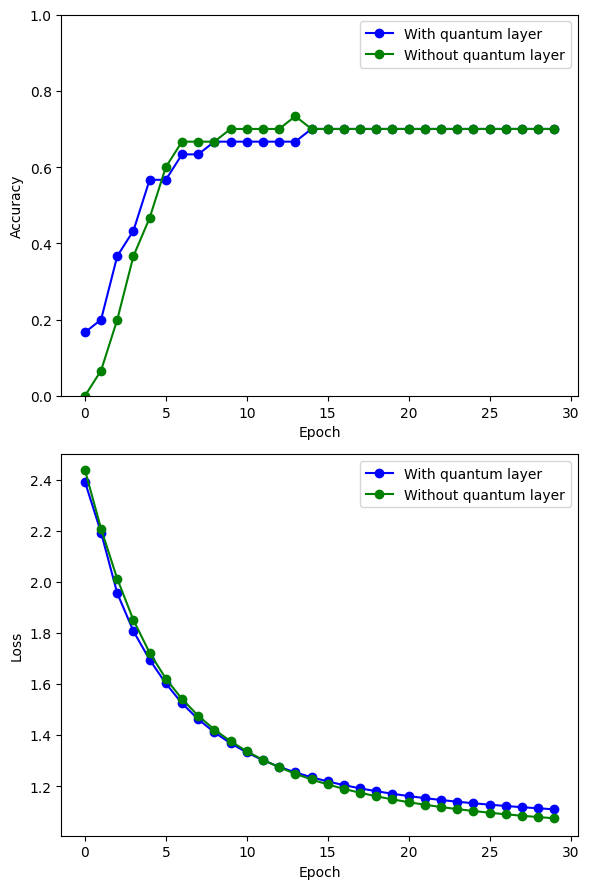

In [12]:
import matplotlib.pyplot as plt

# plt.style.use("seaborn") # this may cause an error
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

# Conclusion

In both approaches, as we train,
- accuracy is maximized
- loss is minimized

In QNN, we see that 
- accuracy is converged to 0.7
- loss is converge to 1.1

In CNN, we see that
- accuracy is converged to 0.7
- loss is converged to 1.1

It seems like both model performs pretty well.

However, this specific evaluation cannot prove that the QNN's performance is better than the other one, or the other way around. To claim such statement, we should use more epochs, train several times, and make more evaluations.

Now, we have successfully implemented the Quanvolutional Neural Network.
Congratulation!

# References

*"Quanvolutional Neural Network, a quantum machine learning model is originally introduced in [Henderson et al. (2019)](https://arxiv.org/abs/1904.04767)"* (Mari, 2020).

- Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan Cook. “Quanvolutional Neural Networks: Powering Image Recognition with Quantum Circuits.” [arXiv:1904.04767](https://arxiv.org/abs/1904.04767), 2019.

PennyLane tutorial link: https://pennylane.ai/qml/demos/tutorial_quanvolution/

# Credits
This notebook is completed by `Myanmar Youths` for `Womanium Quantum + AI 2024` program.
- <a href="https://www.linkedin.com/in/la-wun-nannda-b047681b5/"><u>La Wun Nannda</u></a>
- <a href="https://www.linkedin.com/in/chit-zin-win-46a2a3263/"><u>Chit Zin Win</u></a>